In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

## Nyttige funksjoner

In [17]:
def get_data(filename):
    # Henter og sorterer data fra fil
    data_raw = open(filename, "r").readlines()
    temps = []
    volts = []
    volts_fresh = []
    sides = []
    for i, element in enumerate(data_raw):
        element.strip()
        if i<4:
            temps.append(int(element.split(";")[1]))
        string = (element.split(";")[2][:-1]).replace(",",".")
        volts_fresh.append(float(string))
        if (i+1)%4 == 0:
            sides.append(element.split(";")[0])
            volts.append(volts_fresh)
            volts_fresh = []
    return volts, temps, sides

def rel_volts_black(volts,n):
    # Regner ut spenning målt med overflate n relativt til svart overflate
    rel_volts = []
    for i, volt in enumerate(volts[0]):
        rel_volts.append(volts[n][i]/volt)
    return rel_volts

def rel_volts_err(volts,volts_black):
    # Essensielt samme funksjon som rel_volts_black, men denne brukes når vi regner på usikkerhet
    rel_volts = []
    for i, volt in enumerate(volts_black):
        rel_volts.append(volts[i]/volt)
    return rel_volts

def write_LR_data(rels, temps, filename):
    # Lager fil med data som brukes til lineær regresjon
    with open(filename, 'w') as dataFile:
        dataFile.write("Temperatur;")
        for side in sides[1:]:
            dataFile.write(side)
            if sides[-1] != side:
                dataFile.write(";")
        for i in range(4):
            dataFile.write("\n"+str(temps[i])+";")
            dataFile.write(str(rels[0][i])+";"+str(rels[1][i])+";"+str(rels[2][i]))
    
volts, temps, sides = get_data("Leslie_data1.csv")

## Plotter relative spenninger

<IPython.core.display.Javascript object>


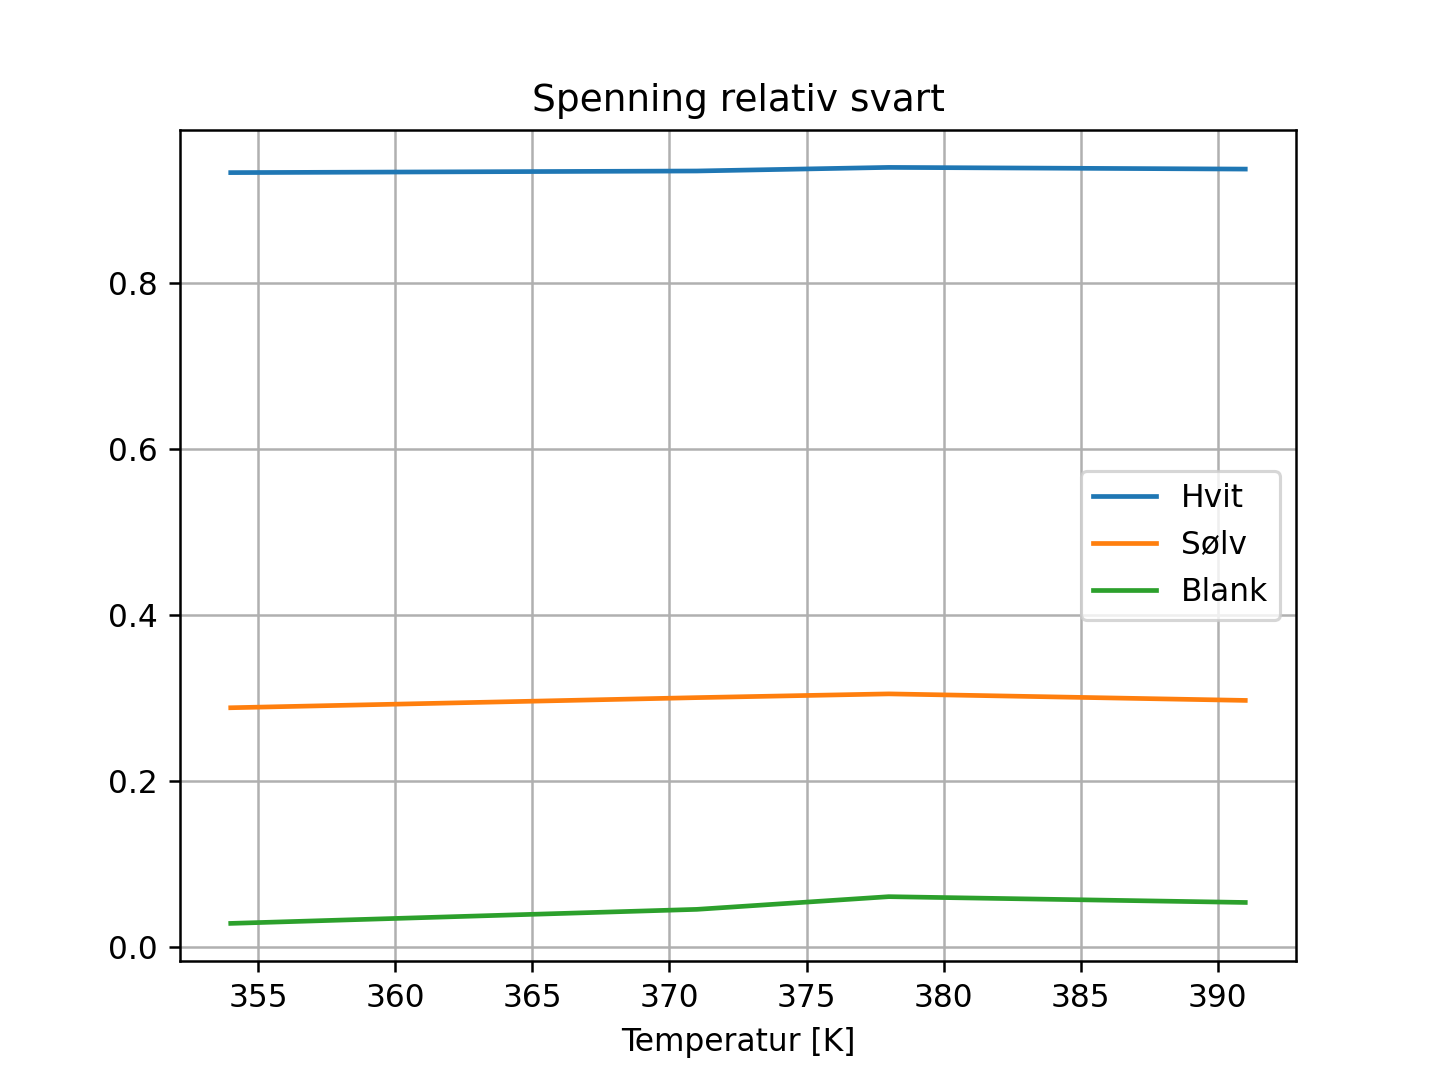

In [18]:
fig0 = plt.figure()
rel1 = rel_volts_black(volts,1)
rel2 = rel_volts_black(volts,2)
rel3 = rel_volts_black(volts,3)
plt.plot(temps,rel1)
plt.plot(temps,rel2)
plt.plot(temps,rel3)

plt.grid()
plt.xlabel("Temperatur [K]")
plt.title("Spenning relativ svart")
plt.legend(sides[1:])

plt.savefig("Leslie_plot1")

## Plotter spenninger

<IPython.core.display.Javascript object>


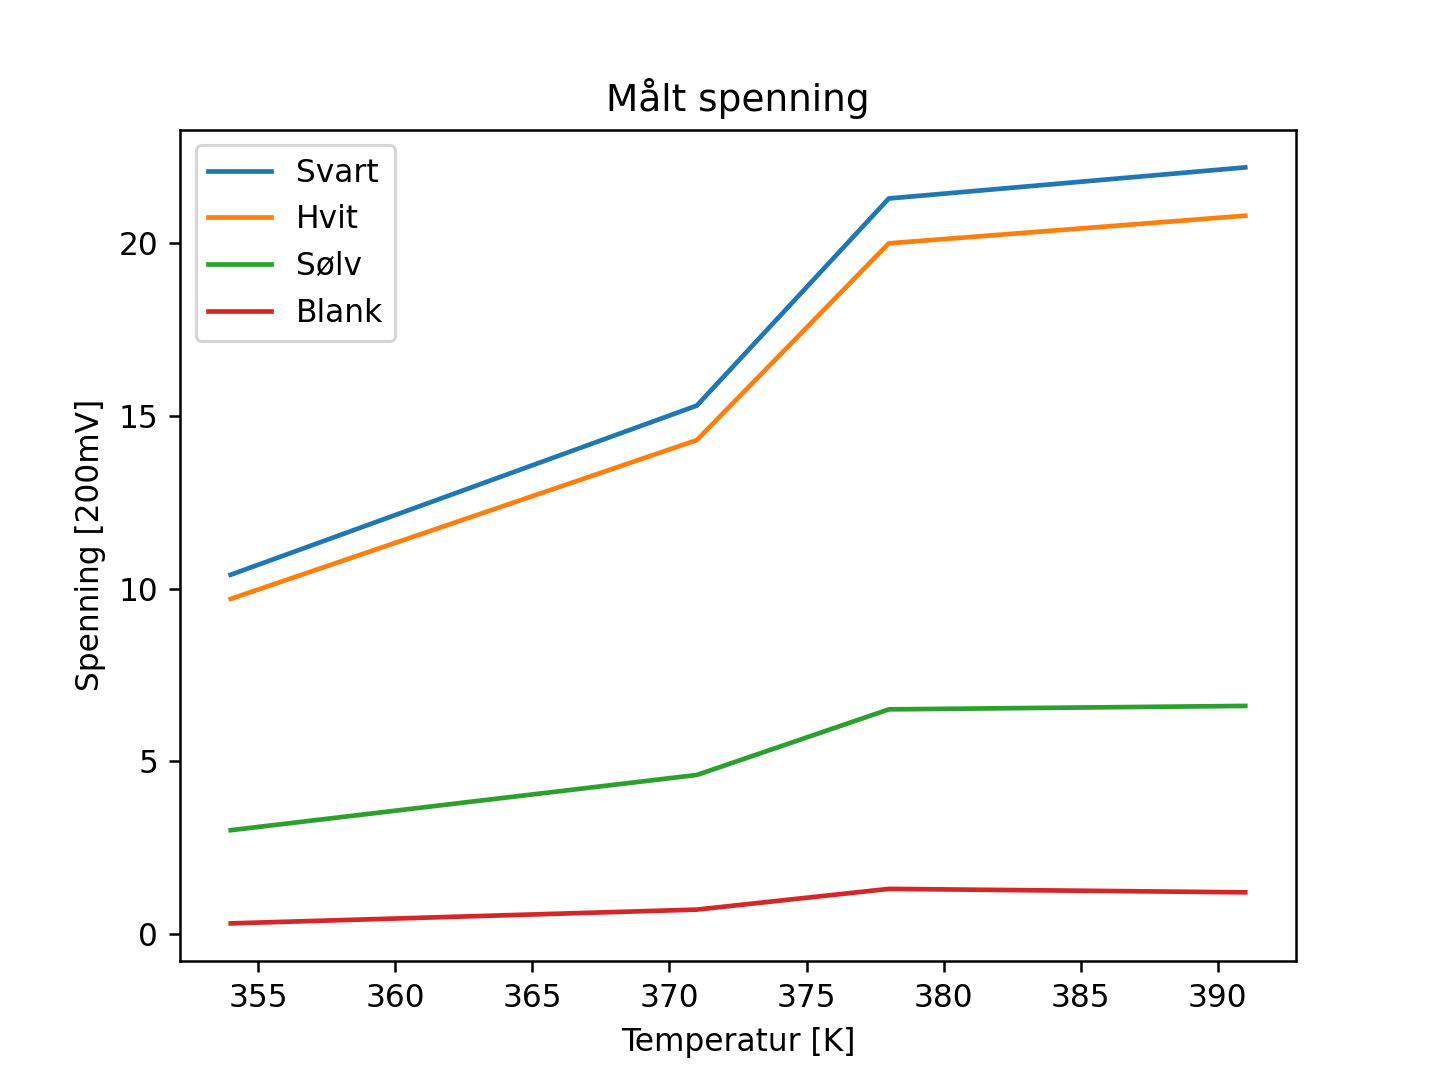

In [6]:
fig1 = plt.figure()
for i in range(4):
    plt.plot(temps,volts[i])
plt.xlabel("Temperatur [K]")
plt.ylabel("Spenning [200mV]")
plt.title("Målt spenning")

plt.legend(sides)

## Data til lineær regresjon

Bruker `write_LR_data` til å lage en fil med verdiene som skal brukes til lineær regresjon. Så ble nettsiden https://arachnoid.com/polysolve/ brukt til å regne ut exp_0 og a_exp i cellen om "Lineær regresjon med usikkerhet".

In [19]:
write_LR_data([rel1,rel2,rel3], temps, "Linear_reg_data.txt")

## Lineær regresjon med usikkerhet

<IPython.core.display.Javascript object>


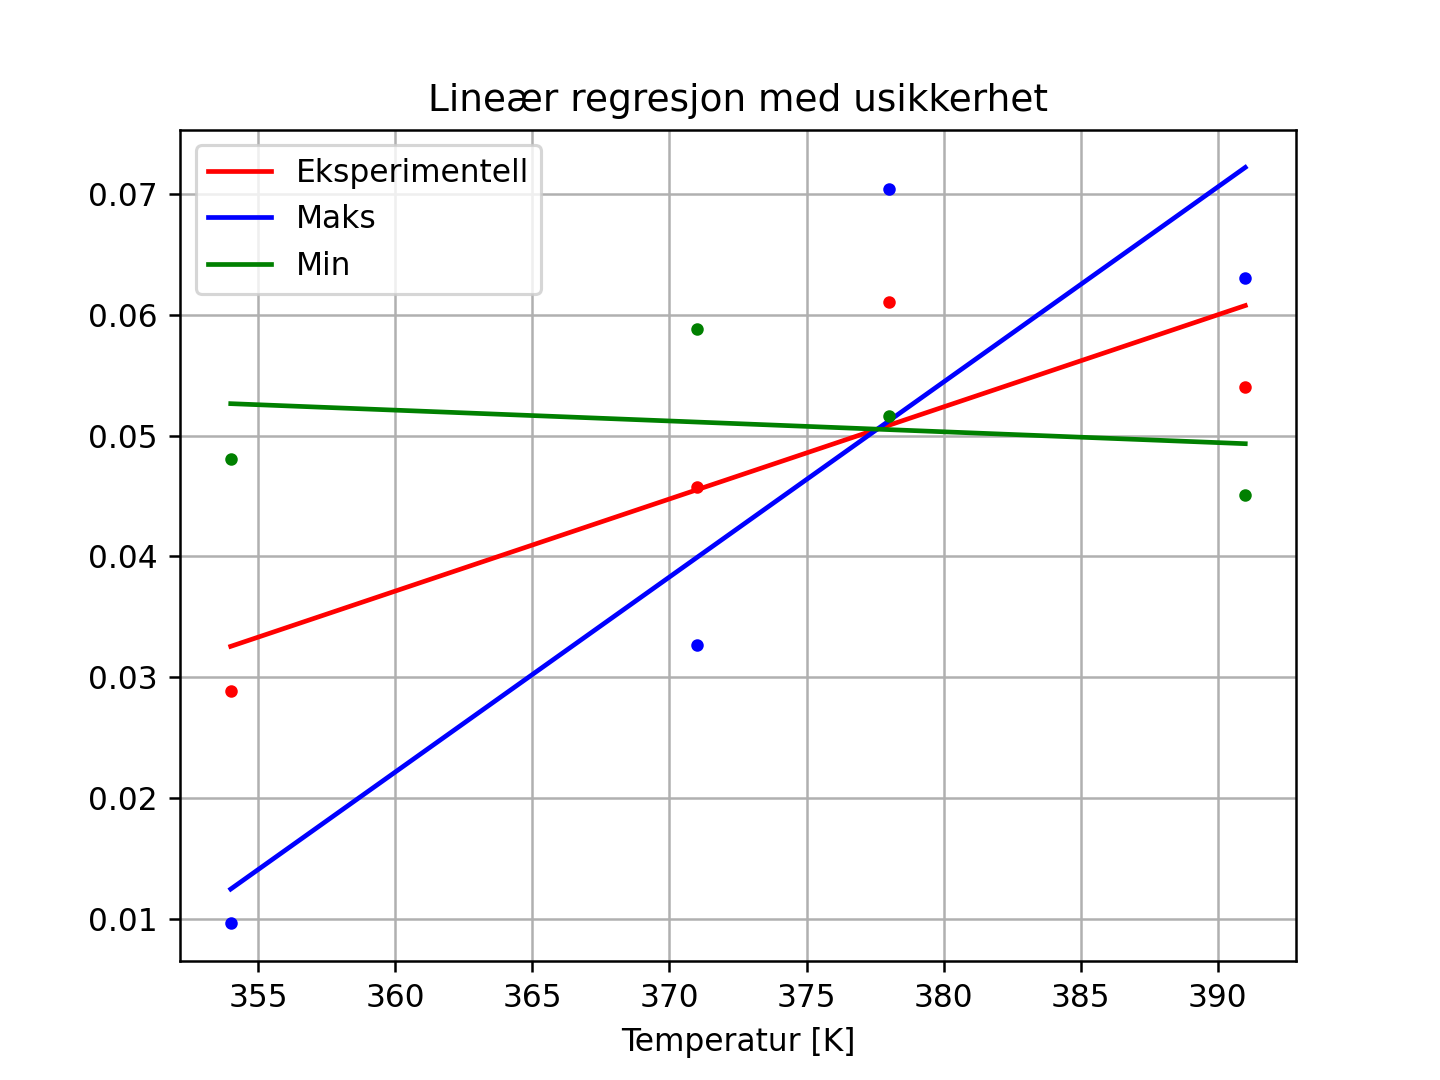

0.0016147344539257772 -8.958789487228637e-05


In [22]:
from scipy import stats

dV = [0,0.2,-0.2]                  # Liste med "usikkerheter"
n = 3                              # Overflaten som skal regnes på 1: Hvit, 2: Sølv, 3: Blank

# Eksperimentell y0 funnet fra lineær regresjon
exp_0 = [8.8465743081822112e-1, 1.9348802346252925e-1, -2.3739994346901044e-1]

# Eksperimentelt stigningstall funnet fra lineære regresjon
a_exp = [1.3695259731085147e-4, 2.7953457558821073e-4, 7.6257327952673575e-4]

volt_n = volts[n]
relative_n = []
x = np.linspace(354,391,100)

# Regner ut alle mulige forskjellige punkter ved å kombinere usikkerhetene
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                volts_curr = [volt_n[0] + dV[i], volt_n[1] + dV[j], volt_n[2] + dV[k], volt_n[3] + dV[l]]
                relative_n.append(rel_volts_err(volts_curr,volts[0]))


slopes = []
ints = []

# Bruker lista med alle mulige punkter til å finne de forskjellige kurvetilpasningene
for arr in relative_n:
    slope, intercept, r, p, se = stats.linregress(temps,arr)
    slopes.append(slope)
    ints.append(intercept)

# Finner kurvene som ga max og min stigningstall
a_max = max(slopes)
a_min = min(slopes)
i_high = slopes.index(a_max)
i_low = slopes.index(a_min)
max_0 = ints[i_high]
min_0 = ints[i_low]


# Plotter resultatene
fig6 = plt.figure()
plt.plot(x, exp_0[n - 1] + x*a_exp[n - 1],"r")
plt.plot(x, max_0 + x*a_max,"b")
plt.plot(x, min_0 + x*a_min,"g")
plt.plot(temps,rel_volts_black(volts,3),".r")
plt.plot(temps,relative_n[i_high],".b")
plt.plot(temps,relative_n[i_low],".g")
plt.legend(["Eksperimentell", "Maks", "Min"])
plt.xlabel("Temperatur [K]")
plt.title("Lineær regresjon med usikkerhet")
plt.grid()

print(a_max, a_min)              # Printer tall som blir brukt i rapporten

#plt.savefig("LR_err")